# Homework #2 – Natural Language Processing

This notebook follows the homework questions sequentially using the files in `homework/homework2/resources` and adapts the workflow from `textbook code.txt`.


## 0) Setup
Install/import required libraries and point to the resources folder.


In [13]:
%pip install --quiet pandas matplotlib seaborn nltk scikit-learn beautifulsoup4 lxml

from pathlib import Path
from collections import Counter

from urllib.request import urlopen
from bs4 import BeautifulSoup

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk.tree import Tree
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sns.set_theme(style="whitegrid")

RESOURCES = Path("../resources")
RESOURCES



[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


PosixPath('../resources')

In [14]:
# NLTK resources used for tokenization/tagging/chunking
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("maxent_ne_chunker_tab")  
nltk.download("maxent_ne_chunker")      
nltk.download("words")                 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucasstarkey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lucasstarkey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucasstarkey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucasstarkey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/lucasstarkey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/lucasstarkey/nltk_data...
[nltk_data]   Package maxent_ne_chunker is alre

True

## 1) Word Tagging (50 points)

### Q1.1 Parse the sentences of the speech.
Using `I-have-a-dream-speech.txt`, tokenize the speech into sentences.


In [15]:
# Load speech text
speech_path = RESOURCES / "I-have-a-dream-speech.txt"
speech = speech_path.read_text(encoding="utf-8")

# Parse sentences
sentences = nltk.sent_tokenize(speech)

print(f"Total sentences: {len(sentences)}")
print("\nFirst 3 sentences:")
for i, s in enumerate(sentences[:3], start=1):
    print(f"{i}. {s}")


Total sentences: 83

First 3 sentences:
1. Five score years ago, a great American, in whose symbolic shadow we stand today, signed the Emancipation Proclamation.
2. This momentous decree came as a great beacon light of hope to millions of Negro slaves who had been seared in the flames of withering injustice.
3. It came as a joyous daybreak to end the long night of their captivity.


### Q1.2 Run parts-of-speech tagging to determine the top named entities.

Following the textbook approach, we:
1. tokenize each sentence,
2. POS-tag each token,
3. run `ne_chunk_sents(..., binary=True)`, and
4. extract entity strings and remove obvious stop/common words.


In [16]:
# Tokenize and POS tag
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]
tagged_sentences = [nltk.pos_tag(tokens) for tokens in tokenized_sentences]

# Named entity chunking (binary NE chunker)
chunked_sentences = nltk.ne_chunk_sents(tagged_sentences, binary=True)


def get_entity_names(tree):
    """Recursively extract named entities from an NLTK chunk tree."""
    entity_names = []
    if hasattr(tree, "label") and tree.label:
        if tree.label() == "NE":
            entity_names.append(" ".join([child[0] for child in tree]))
        else:
            for child in tree:
                entity_names.extend(get_entity_names(child))
    return entity_names


# Collect all entity names
entity_names = []
for tree in chunked_sentences:
    entity_names.extend(get_entity_names(tree))

# Basic cleanup: drop very short entities and common stop words
stop_words = set(nltk.corpus.stopwords.words("english"))
filtered_entities = [
    e.strip()
    for e in entity_names
    if len(e.strip()) > 1 and e.lower() not in stop_words
]

entity_counts = Counter(filtered_entities)
top_10_entities = entity_counts.most_common(10)

top_10_entities


[('Negro', 11),
 ('America', 5),
 ('American', 4),
 ('Mississippi', 4),
 ('Black', 3),
 ('God', 3),
 ('Alabama', 3),
 ('Georgia', 3),
 ('New York', 2),
 ('Independence', 1)]

### Q1.3 Plot Named Entities (X-axis) vs Frequency (Y-axis).


/var/folders/8n/sgg6k_m56231b9jnlnh3wv1c0000gn/T/ipykernel_39966/3457273399.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_df, x="Named Entity", y="Frequency", palette="viridis")


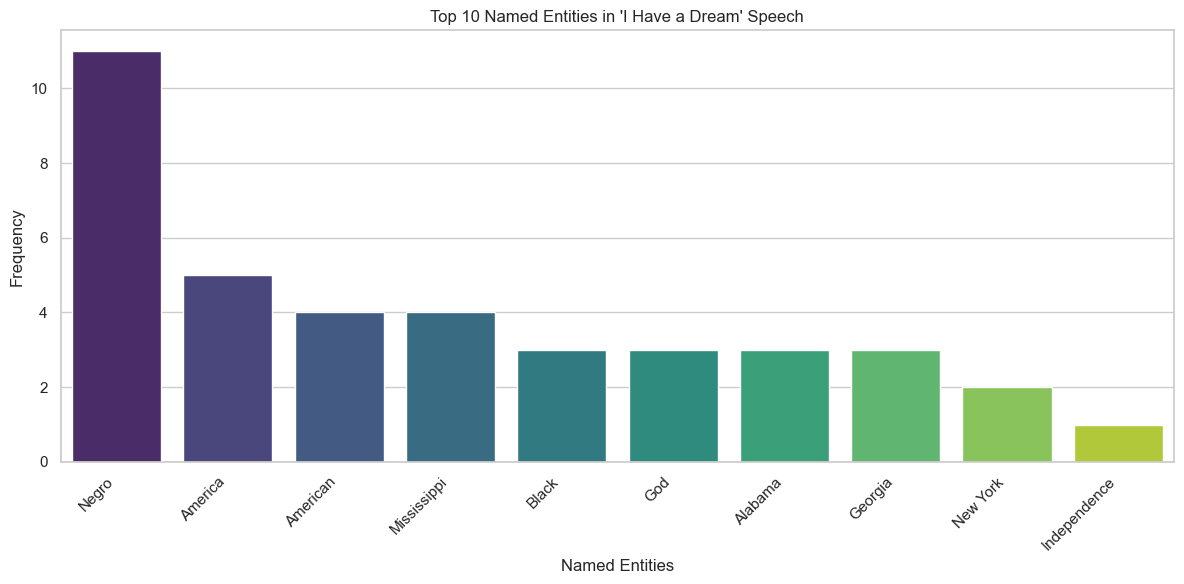

,Named Entity,Frequency
0,Negro,11
1,America,5
2,American,4
3,Mississippi,4
4,Black,3
5,God,3
6,Alabama,3
7,Georgia,3
8,New York,2
9,Independence,1


In [17]:
top_df = pd.DataFrame(top_10_entities, columns=["Named Entity", "Frequency"])

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_df, x="Named Entity", y="Frequency", palette="viridis")
ax.set_title("Top 10 Named Entities in 'I Have a Dream' Speech")
ax.set_xlabel("Named Entities")
ax.set_ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

top_df


### Q1.4 What do you notice about the top 10 named entities? Does anything surprise you?

**Answer (rationale):**
- Okay so the top entities are: `Negro (11)`, `America (5)`, `American (4)`, `Mississippi (4)`, `Black (3)`, `God (3)`, `Alabama (3)`, `Georgia (3)`, `New York (2)`, `Independence (1)`... which is very on-theme for civil rights + U.S. identity + specific Southern states.
- Pattern I notice immediately: place names + identity words keep showing up. Makes sense, because Dr. King keeps switching between American ideals and actual conditions in places like Mississippi/Alabama/Georgia.
- What surprised me most is `Negro` being #1. Historically that tracks for 1963 language, but reading it now it still jumps out because modern wording is different.
- Also, quick nerd caveat: entity extraction is imperfect, so splitting like `America` vs `American` can fragment counts. So I trust the trend, not every exact number as absolute truth.


### Textbook Workflow Add-on: Obama 2009 Speech (Scrape → Save → POS/NE)

This follows the textbook scrape/save/POS/NE workflow on President Obama's 2009 address.


Saved Obama speech to: resources/obama2009.txt
Speech length (chars): 34293
First 500 chars: Madam Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States--she's around here somewhere: I have come here tonight not only to address the distinguished men and women in this great Chamber, but to speak frankly and directly to the men and women who sent us here. I know that for many Americans watching right now, the state of our economy is a concern that rises above all others, and rightly so. If you haven't been personally affected by this recession, you probably

Total Obama sentences: 287

First 3 Obama sentences:
1. Madam Speaker, Mr. Vice President, Members of Congress, the First Lady of the United States--she's around here somewhere: I have come here tonight not only to address the distinguished men and women in this great Chamber, but to speak frankly and directly to the men and women who sent us here.
2. I know that for many Americans watching right now, 

,Entity Name,Freq
0,American,23
1,America,17
2,Congress,6
3,United States,4
4,Iraq,4
5,Democrats,3
6,South Carolina,2
7,Applause,2
8,Afghanistan,2
9,Social Security,2


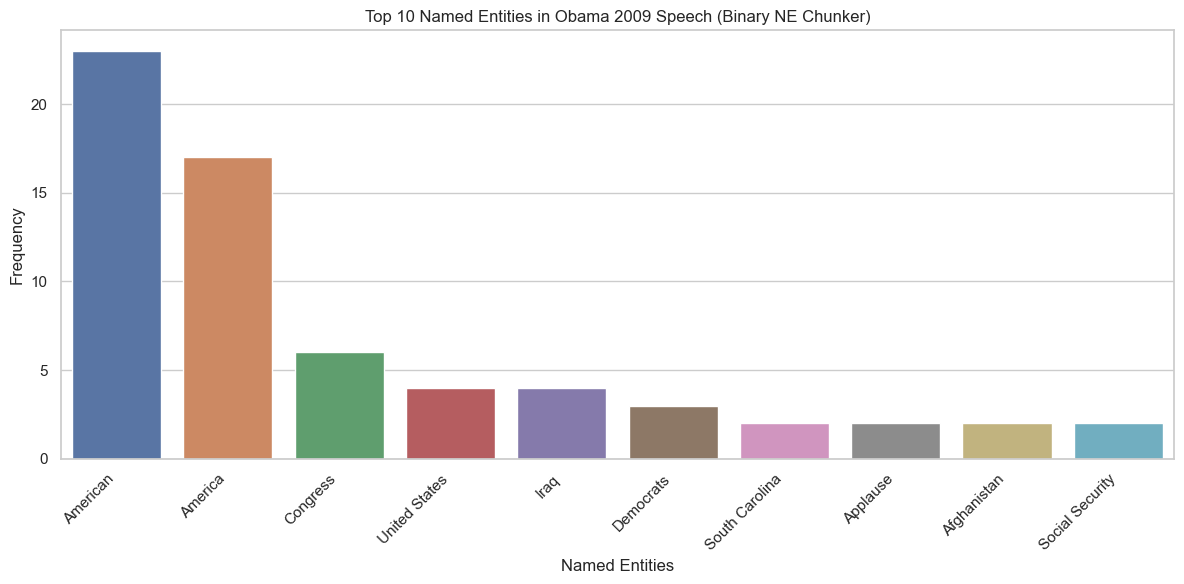

In [18]:
# ------------------------------------------------------------
# Textbook Workflow Add-on: Obama 2009 Speech (Scrape → Save → POS/NE)
# ------------------------------------------------------------

from urllib.request import urlopen
from bs4 import BeautifulSoup
from pathlib import Path

# define the resources directory (used for saving the text file)
OBAMA_RESOURCES = Path("resources")
OBAMA_RESOURCES.mkdir(parents=True, exist_ok=True)

# 1) Visit The American Presidency Project page and load HTML
wp = "https://www.presidency.ucsb.edu/node/286218"
pageSource = urlopen(wp).read()
# use the built‑in HTML parser (avoids needing lxml);
# alternatively you could install lxml with `%pip install lxml`
pa2009 = BeautifulSoup(pageSource, "html.parser")

# 2) Locate the speech content (as in the textbook)
maincontainer = pa2009.find("div", class_="main-container container")
if maincontainer is None:
    raise ValueError("Could not find main container div. Page structure may have changed.")

content = maincontainer.find("div", class_="field-docs-content")
if content is None:
    raise ValueError("Could not find field-docs-content div. Page structure may have changed.")

content_p = content.find_all("p")
if not content_p:
    raise ValueError("No paragraphs found under field-docs-content. Page structure may have changed.")

# 3) Extract paragraph text and join into a single speech string
paragraphs = [p.get_text().strip() for p in content_p]
speech_obama = " ".join(paragraphs)

# 4) Save speech to a local plain text file (store in RESOURCES for consistency)
obama_out_path = OBAMA_RESOURCES / "obama2009.txt"
obama_out_path.write_text(speech_obama, encoding="utf-8")

print("Saved Obama speech to:", obama_out_path)
print("Speech length (chars):", len(speech_obama))
print("First 500 chars:", speech_obama[:500])

# 5) Parse the sentences of the speech
sentences_obama = nltk.sent_tokenize(speech_obama)
print("\nTotal Obama sentences:", len(sentences_obama))
print("\nFirst 3 Obama sentences:")
for i, s in enumerate(sentences_obama[:3], start=1):
    print(f"{i}. {s}")

# 6) Tokenize each sentence and POS tag the tokens
tokenized_sentences_obama = [nltk.word_tokenize(sentence) for sentence in sentences_obama]
tagged_sentences_obama = [nltk.pos_tag(tokens) for tokens in tokenized_sentences_obama]

# 7) Chunk named entities (binary NE chunker, like the textbook)
chunked_sentences_obama = nltk.ne_chunk_sents(tagged_sentences_obama, binary=True)

# 8) Reuse (or define) the recursive NE extraction function
def get_entity_names(tree):
    """Recursively extract named entities from an NLTK chunk tree."""
    entity_names = []
    if hasattr(tree, "label") and tree.label:
        if tree.label() == "NE":
            entity_names.append(" ".join([child[0] for child in tree]))
        else:
            for child in tree:
                entity_names.extend(get_entity_names(child))
    return entity_names

# 9) Extract and count entity names
entity_names_obama = []
for tree in chunked_sentences_obama:
    entity_names_obama.extend(get_entity_names(tree))

from collections import Counter
import pandas as pd

data_names_obama = Counter(entity_names_obama)
df_obama_entities = pd.DataFrame(list(data_names_obama.items()), columns=["Entity Name", "Freq"])
df_obama_entities = df_obama_entities.sort_values("Freq", ascending=False).reset_index(drop=True)

print("\nTop 10 named entities (Obama 2009):")
display(df_obama_entities.head(10))

# Optional: quick plot (matches your existing style)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_obama_entities.head(10),
    x="Entity Name",
    y="Freq",
    hue="Entity Name",
    legend=False
)
ax.set_title("Top 10 Named Entities in Obama 2009 Speech (Binary NE Chunker)")
ax.set_xlabel("Named Entities")
ax.set_ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 2) Tweets and LDA (50 points)

### Q2.1 Using the provided training and testing tweets files, perform LDA.

This section loads train/test tweets, vectorizes text, fits an LDA model, and inspects topic-word outputs.


In [19]:
# Resolve tweet dataset directory robustly regardless notebook launch directory
candidate_dirs = [
    Path('../resources'),
    Path('resources'),
    Path('homework/homework2/resources'),
]

for d in candidate_dirs:
    if (d / 'Train_QuantumTunnel_Tweets.csv').exists() and (d / 'Test_QuantumTunnel_Tweets.csv').exists():
        tweets_resources = d
        break
else:
    raise FileNotFoundError('Could not locate Train/Test_QuantumTunnel_Tweets.csv in expected resource folders.')

train_path = tweets_resources / 'Train_QuantumTunnel_Tweets.csv'
test_path = tweets_resources / 'Test_QuantumTunnel_Tweets.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Using resources dir:', tweets_resources)
print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)
print('Train columns:', train_df.columns.tolist())
print('Test columns:', test_df.columns.tolist())

train_df.head()


Using resources dir: ../resources
Train shape: (324, 3)
Test shape: (163, 3)
Train columns: ['Data_Science', 'Date', 'Tweet']
Test columns: ['id', 'Date', 'Tweet']


,Data_Science,Date,Tweet
0,0,11/04/15,Oh... It is even worse... They are playing xma...
1,1,11/12/13,RStudio OS X Mavericks Issues Resolved http://...
2,0,02/03/14,A Hubble glitch has produced this stellar artw...
3,0,25/02/14,@kwbroman Good question. I've done separate-pa...
4,1,16/12/13,"Data and visualization year in review, 2013 ht..."


In [20]:
# Ensure the expected text column exists
text_col = "Tweet"
assert text_col in train_df.columns and text_col in test_df.columns, "Expected a 'Tweet' column in both files."

# Vectorize tweet text for LDA
vectorizer = CountVectorizer(
    stop_words="english",
    lowercase=True,
    max_df=0.95,
    min_df=2,
)

X_train_counts = vectorizer.fit_transform(train_df[text_col].astype(str))
X_test_counts = vectorizer.transform(test_df[text_col].astype(str))

# Fit LDA
n_topics = 5
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method="batch",
)
lda.fit(X_train_counts)


def print_top_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_terms = [feature_names[i] for i in top_indices]
        print(f"Topic {topic_idx + 1}: {', '.join(top_terms)}")


feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words=10)


Topic 1: http, https, rugby, guardian, national, rwc2015, make, technology, making, great
Topic 2: http, data, https, science, new, odisummit, xmas, work, review, better
Topic 3: data, http, neo4j, science, like, python, yay, hadoop, parry_joe, quantum_tunnel
Topic 4: http, physics, time, quantum, using, xkcd, light, learning, post, physicists
Topic 5: https, great, rugby, star, datascience, wars, new, london, year, bigdatadebate


In [24]:
# Topic distribution for test tweets
test_topic_dist = lda.transform(X_test_counts)
test_topic_ids = test_topic_dist.argmax(axis=1)

test_results = test_df.copy()
test_results["Predicted_Topic"] = test_topic_ids
test_results["Topic_Confidence"] = test_topic_dist.max(axis=1)

test_results[["Tweet", "Predicted_Topic", "Topic_Confidence"]].head(15)


,Tweet,Predicted_Topic,Topic_Confidence
0,"Staying late, but things brighten up! http://t...",3,0.505386
1,"Yes, I'm a geek and I'm attending The Blackett...",4,0.547000
2,This is not an ex-parrot: 'Extinct' night parr...,3,0.798547
3,VIDEO: The Hit: World Cup glory for Carter #ru...,4,0.451831
4,Interested in finding out more about #DataScie...,4,0.866276
5,Visual interpretation of interaction terms in ...,2,0.475365
6,Revisiting the Inaguration Lecture of my mate ...,4,0.598443
7,Great talk and good explanations from @r_trott...,1,0.497581
8,"Mandarin is hard to master. Machines, like hum...",4,0.796750
9,The R Backpages http://t.co/yTI2ltdZba,3,0.596036


### Q2.2 Show some predictions on test data. Does it look accurate?

To make predictions interpretable, we map each topic to a rough human label based on top words.


**Answer (rationale):**
- Big picture: the predictions are kinda good for broad themes, but not super crisp. A lot of confidence scores are in the `~0.45` to `~0.60` zone, which feels like the model is basically saying, "eh... probably this topic?"
- Where it *does* look solid: domain-heavy tweets. Example: tweet 4 (`#DataScience`, `#MachineLearning`) lands in Topic 5 with confidence `0.866`; tweet 8 (`#DeepLearning`) also lands in a data/ML-ish topic with `0.797`. Nice.
- Where it gets fuzzy: short/ambiguous posts. Example: tweet 0 ("Staying late, but things brighten up!") gets Topic 4 at `0.505`, which is barely convincing and not very interpretable.
- Why this happens: topic words include lots of `http`/`https`, so noise from links is still strong. So I’d call this useful for exploration and clustering vibes, but not reliable enough to treat as high-precision classification without better preprocessing.
